In [787]:
%%html
<style>
div.container#notebook-container {width: 1300px}
</style>

# Import stuff

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib

matplotlib.use("Cairo")  # alternatives: nbAgg
%matplotlib inline
# %matplotlib notebook
from matplotlib import rcParams

rcParams["font.family"] = "sans-serif"
rcParams['font.sans-serif'] = ['DejaVu Sans Mono']
rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
# plt.style.use('default')

import seaborn
from tqdm.auto import tqdm
from multiprocessing import Pool, RLock, freeze_support

import time
import datetime
import pandas as pd
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
import os
import re
import numpy as np
import random
import networkx as nx
import pickle

freeze_support()  # for Windows support
tqdm.set_lock(RLock())  # for managing output contention

# Import data load and process functions
from main_dycause_mp_new import dycause_causal_discover
import utility_funcs.data_load_funcs as data_funcs

# Import data and graph plot functions
import utility_funcs.graph_draw as gd

# Import modified interval process functions
import dycause_lib.method_improves as meth_imp

# Import root cause analysis functions
from dycause_lib.rca import analyze_root, normalize_by_column, search_path, bfs, case_rca_backtrace
from utility_funcs.evaluation_function import pr_stat, print_prk_acc, my_acc
import utility_funcs.exp_result_analyze as exp_ana

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Domain Knowledge

In [3]:
#------------- Domain Knowledge --------------------------------------
only_source_cols = ['inBytes', 'inMulticast', 'inPackets',
                    'tcpPkgInsegs', 'udpInDatagrams']
only_target_cols = ['outBytes', 'outPackets',
                    'tcpPkgOutsegs', 'tcpPkgRetranssegs',
                    'udpOutDatagrams']

def get_only_source_target_idx(only_source_cols, only_target_cols, col_list):
    def find_match_ind(simple_column):
        for i, c in enumerate(col_list):
            if gd.remove_parenthesis(c) == simple_column:
                return i
#         assert False, f'Column {simple_column} not found in col_list!'
        return -1
    source_ids = [find_match_ind(i) for i in only_source_cols]
    source_ids = [i for i in source_ids if i!=-1]
    target_ids = [find_match_ind(i) for i in only_target_cols]
    target_ids = [i for i in target_ids if i != -1]
    return source_ids, target_ids

## Graph Drawing Column Sets

In [22]:
#--------- Case 1,2,5,6 Net & Runtime Metrics ----------
all_columns_d_1 = {
    'eth0': ['(iface=eth0)inPackets', '(iface=eth0)inPercent', '(iface=eth0)inMulticast', 
             '(iface=eth0)outPercent', '(iface=eth0)outPackets',
             '(iface=eth0)totalBytes', '(iface=eth0)totalPackets'],
    'cpu': ['busy', 'iowait', 'softirq', 'nice', 'system', 'user', 'switches'], 
    'kernel': ['kernelFilesAllocated'], 
    'load': ['load1', 'load5'],
    'memory': ['memBuffers', 'memCached', 'memShmem', 'memUsedPercent', 'memAvailablePercent'], 
    'tcp': ['retrans', 'tcpAbortOnTimeout', 'tcpDelayedACKLocked', 'tcpLostRetransmit', 'tcpPkgInsegs', 'tcpPkgOutsegs',
    'tcpPkgRetranssegs', 'tcpTW'],
    'socket': ['ssClosed', 'ssEstab', 'ssOrphaned', 'ssTimeWait'],
    'udp': ['udpInDatagrams', 'udpNoPorts', 'udpOutDatagrams', 'udpIgnoreMulti_Diff']
}
# --------- Case 7 all_columns
all_columns_d_3 = {
    "eth0": [
        "(iface=eth0)inPercent",
        "(iface=eth0)inPackets",
        "(iface=eth0)outPercent",
        "(iface=eth0)outPackets",
        "(iface=eth0)totalBytes",
        "(iface=eth0)totalPackets",
    ],
    "cpu": ["busy", "iowait", "softirq", "system", "user", "switches"],
    "kernel": ["kernelFilesAllocated"],
    "load": ["load1", "load5"],
    "memory": ["memBuffers", "memCached", "memShmem", "memUsedPercent", "memAvailablePercent"],
    "tcp": [
        "retrans",
        "tcpAbortOnTimeout",
        "tcpDelayedACKLocked",
        "tcpPkgInsegs",
        "tcpPkgOutsegs",
        "tcpTW",
    ],
    "socket": ["ssClosed", "ssEstab", "ssOrphaned", "ssTimeWait"],
    "udp": ["udpInDatagrams", "udpNoPorts", "udpOutDatagrams", "udpIgnoreMulti_Diff"],
    "disk": [
        "(mount=/data00)df.statistics.used.percent",
        "(mount=/data00)df.statistics.used",
        "(mount=/data00)df.statistics.total",
        "(mount=/data00)df.inodes.free.percent",
        "(mount=/data00)df.bytes.free.percent",
        "(mount=/)df.statistics.used.percent",
        "(mount=/)df.statistics.used",
        "(mount=/)df.statistics.total",
        "(mount=/)df.bytes.free.percent",
    ],
    "diskio": [
        "(device=sda)disk.io.write",
        "(device=sda)disk.io.w_wait",
        "(device=sda)disk.io.util",
        "(device=sda)disk.io.read",
        "(device=sda)disk.io.await",
        "(device=sda)disk.io.read_bytes_Diff",
        "(device=sda)disk.io.write_bytes_Diff",
        "(device=sdb)disk.io.write",
        "(device=sdb)disk.io.w_wait",
        "(device=sdb)disk.io.util",
        "(device=sdb)disk.io.read",
        "(device=sdb)disk.io.await",
        "(device=sdb)disk.io.read_bytes_Diff",
        "(device=sdb)disk.io.write_bytes_Diff",
    ],
}

columns_by_case = {}
color_info_by_case = {}

def extract_cols(d):
    all_columns = []
    for k, v in d.items():
        all_columns += sorted(v)
    return all_columns
columns_by_case['case1'] = extract_cols(all_columns_d_1)
color_info_by_case['case1'] = gd.get_node_colors(all_columns_d_1, columns_by_case['case1'])


columns_by_case['case7'] = extract_cols(all_columns_d_3)
color_info_by_case['case7'] = gd.get_node_colors(all_columns_d_3, columns_by_case['case7'])

### SRE Labelled Edges

In [1051]:
case1to6_correct_edges = [
    ('ssTimeWait',  'tcpTW'),
    ('ssClosed', 'tcpTW'),
    ('(iface=eth0)totalPackets', '(iface=eth0)outPackets'),
    ('(iface=eth0)inPackets', '(iface=eth0)totalBytes'),
    ('(iface=eth0)inPackets', '(iface=eth0)totalPackets'),
    ('(iface=eth0)totalPackets', '(iface=eth0)outBytes'), ('(iface=eth0)totalPackets', '(iface=eth0)outPackets'), ('(iface=eth0)totalPackets', '(iface=eth0)outPercent'),
    ('tcpTW', 'ssTimeWait'),
    ('tcpDelayedACKLocked', 'load5'),
    ('retrans', 'tcpPkgRetranssegs'),
    ('memBuffers', 'memAvailablePercent'),
    ('load5', 'tcpDelayedACKLocked'),
    ('tcpTW', 'ssClosed')
]
case1_correct_edges = [
    ('(iface=eth0)totalPackets', '(iface=eth0)outPackets'),
    ('(iface=eth0)totalPackets', 'tcpPkgOutsegs'),
    ('ssClosed', 'tcpTW'),

]
case1to6_wrong_edges = [
    ('switches', 'udpOutDatagrams'),
    ('memBuffers', '(iface=eth0)inPercent'),
    ('ssEstab', 'udpOutDatagrams'),
    ('memBuffers', '(iface=eth0)totalPackets'),
    ('(iface=eth0)totalPackets', 'tcpTW'),
    ('(iface=eth0)inPercent', 'memBuffers'),
    ('(iface=eth0)inBytes', 'memBuffers'), ('(iface=eth0)inPackets', 'memBuffers'), ('(iface=eth0)inPercent', 'memBuffers'),
    ('tcpPkgInsegs', 'memBuffers'),
    ('udpInDatagrams', 'memBuffers'),
    ('memBuffers', 'udpOutDatagrams')
]
case1_wrong_edges = [
    ('busy', 'iowait'),
    ('iowait', 'busy'),
    ('system', 'switches'),
    ('memUsedPercent', 'ssClosed'),
    ('switches', 'user'),
    ('nice', 'tcpAbortOnTimeout'),
    ('memUsedPercent', 'ssTimeWait')
]
for t in case1to6_correct_edges+case1_correct_edges+case1to6_wrong_edges+case1_wrong_edges:
    for n in t:
        if n not in columns_by_case['case1']:
            print(n)

(iface=eth0)outBytes
(iface=eth0)inBytes


## Case 1

In [21]:
data_out_dir = "sample_data/case1"
plot_out_dir = 'plot_out_dir'

### Case 1 Direction Hints of History Metrics

In [10]:
def calc_mat_sim_diff(mat_list):

    bmat_list = [mat > 0 for mat in mat_list]
    base = bmat_list[0]
    n_sim_l = []
    n_diff_l = []
    for bmat in bmat_list[1:]:
        n_sim = float(np.sum(bmat & base))
        n_sim_l.append(n_sim)
        n_diff = float(np.sum(np.logical_xor(bmat, base)))
        n_diff_l.append(n_diff)
#         print("Num of same edges: {}, diff edges: {}, out of: {} edges.".format(n_sim, n_diff, 
#                                                                                 np.prod(bmat.shape)))
        base = bmat
#     print(n_sim_l, n_diff_l)
    return n_sim_l, n_diff_l

sign = 0.1
step = 30

_df = pd.read_csv(os.path.join(data_out_dir, "normal_df_seq", f"merged_df_7.csv"),
                                    index_col=0)
_df.index = pd.to_datetime(_df.index)
normal_profile_cols = list(_df.columns)


    
only_source_ids, only_target_ids = get_only_source_target_idx(only_source_cols, only_target_cols,
                                             list(normal_profile_cols))



n_sim_data = []
n_diff_data = []
for ntop in range(350, 400, 50):
    mat_list = []
    # ---- These temp files are the results of the algorithm 1 in the paper with
    # ---- parameter: alpha=0.1, delta=30, p=8 on the sequential data sample_data/case1/normal_df_seq
    for _ in ['exp_rets_20220304_195007.pkl',
         'exp_rets_20220304_195108.pkl',
         'exp_rets_20220304_195210.pkl',
         'exp_rets_20220304_195311.pkl',
         'exp_rets_20220304_195412.pkl',
         'exp_rets_20220304_195513.pkl',
         'exp_rets_20220304_195614.pkl',
         'exp_rets_20220304_195716.pkl']:
        fname = "temp_results/" + _
        with open(fname, "rb") as f:
            _exp_ret = pickle.load(f)

        meth_imp.build_intervals_special(_exp_ret['local_results'], sign, _df.shape[0], step, _df.shape[1])
        _exp_ret['dcc_special'] = meth_imp.generate_DCC(_exp_ret['local_results'], _df.shape[0], _df.shape[1], interval_key="intervals_special")
        hints = meth_imp.get_dir_hints_from_dcc(
            _exp_ret["dcc"], _df.shape[1], 250)
        transition_matrix_special = meth_imp.global_thresholding(
            _exp_ret['dcc'], _df.shape[1], normal_axis='none',
            ntop=ntop,
            hints=hints,
            only_source_ids=only_source_ids,
            only_target_ids=only_target_ids)
        gd.mat_summary(transition_matrix_special)
        mat_list.append(transition_matrix_special)
        
    n_sim_l, n_diff_l = calc_mat_sim_diff(mat_list)
    n_sim_data.append(n_sim_l)
    n_diff_data.append(n_diff_l)

Num of nonzeros: 350, min=0.0, max=3158.0
Num of nonzeros: 350, min=0.0, max=3096.0
Num of nonzeros: 350, min=0.0, max=3247.0
Num of nonzeros: 350, min=0.0, max=3125.0
Num of nonzeros: 350, min=0.0, max=2827.0
Num of nonzeros: 350, min=0.0, max=2798.0
Num of nonzeros: 350, min=0.0, max=3247.0
Num of nonzeros: 350, min=0.0, max=2434.0


In [14]:
bmat_list = [mat > 0 for mat in mat_list]
r = bmat_list[0]
for bmat in bmat_list[1:]:
    r = r & bmat
xs, ys = np.nonzero(r)
normal_profile_hints = sorted([(_[0], _[1], 0) for _ in list(zip(xs, ys))])


def remove_dup_hints(hints):
    hints = sorted(hints)
    i = 0
    r = [hints[0]]
    for i in range(len(hints) - 1):
        if hints[i + 1] == r[-1]:
            continue
        else:
            r.append(hints[i + 1])
    return r


_data_idx_to_graph_idx, _graph_idx_to_data_idx = gd.construct_d2g_map_dict(
    list(_df.columns), columns_by_case['case1'], print_info=False
)
normal_profile_hints_filtered = gd.filter_hints(
    normal_profile_hints, _data_idx_to_graph_idx
)
for x, y, _ in normal_profile_hints_filtered:
    #     print(f"{x:<2}:{dycause_input.columns[x]:<25} --> {y:<2}:{dycause_input.columns[y]:<25}")
    print(f"{columns_by_case['case1'][x]:<25} --> {columns_by_case['case1'][y]:<25}")

(iface=eth0)inPackets     --> (iface=eth0)outPackets   
(iface=eth0)inPackets     --> (iface=eth0)totalBytes   
(iface=eth0)inPackets     --> ssEstab                  
(iface=eth0)inPackets     --> switches                 
(iface=eth0)inPackets     --> tcpPkgOutsegs            
(iface=eth0)inPackets     --> udpOutDatagrams          
(iface=eth0)totalPackets  --> ssEstab                  
(iface=eth0)totalPackets  --> switches                 
softirq                   --> switches                 
tcpPkgInsegs              --> (iface=eth0)totalBytes   
tcpPkgInsegs              --> ssEstab                  
tcpPkgInsegs              --> switches                 


### Case 1 Host Evolution Diagram

In [39]:
# ---- These temp files are the results of the algorithm 1 in the paper with
# ---- parameter: alpha=0.1, delta=30, p=8. The data is in sample_data/case1/anomaly_df_seq.
# The exp_rets are calculated on the order of input dataframes.
# Thus the time order is also reversed the same as input dataframes.
case1_anomaly_seq_exp_rets = [
]

In [ ]:
sign = 0.1
step = 30
list_mat_list = []
for ntop in range(500, 550, 50):
    mat_list = []
    for i, fname in tqdm(enumerate(case1_anomaly_seq_exp_rets)):
        with open('temp_results/' + fname, "rb") as f:
            exp_ret = pickle.load(f)
        _df = pd.read_csv(os.path.join(data_out_dir, "anomaly_df_seq", f"df_{i}.csv"),
                                        index_col=0)
        _df.index = pd.to_datetime(_df.index)
        only_source_ids, only_target_ids = get_only_source_target_idx(only_source_cols, only_target_cols,
                                                 list(_df.columns))

        meth_imp.build_intervals_special(exp_ret['local_results'], sign, _df.shape[0], step, _df.shape[1])
        exp_ret['dcc_special'] = meth_imp.generate_DCC(exp_ret['local_results'], _df.shape[0], _df.shape[1], 
                                                       interval_key="intervals_special")
        data_idx_to_graph_idx, graph_idx_to_data_idx = gd.construct_d2g_map_dict(list(_df.columns), 
                                                                  _df.columns)
        filtered_df = gd.filter_df(_df, graph_idx_to_data_idx, len(_df.columns))
        exp_ret["filtered_dcc"] = gd.filter_dcc(exp_ret["dcc"], len(_df.columns), graph_idx_to_data_idx)
        exp_ret["filtered_dcc_special"] = gd.filter_dcc(exp_ret["dcc_special"], len(_df.columns), graph_idx_to_data_idx)
        # hints from anomaly dcc
        hints = meth_imp.get_dir_hints_from_dcc(exp_ret["filtered_dcc"], len(_df.columns), 250)

        o_s_ids, o_t_ids = get_only_source_target_idx(only_source_cols, only_target_cols,
                                                     list(_df.columns))
        # for ntop in [50]:
        mat, candidates = meth_imp.global_thresholding(
            exp_ret["filtered_dcc_special"], len(_df.columns), normal_axis='none', 
            ntop=ntop, only_source_ids=o_s_ids,
            only_target_ids=o_t_ids, 
            hints=hints,
            return_candidates=True
        )
        exp_ret['mat'] = mat
        exp_ret['candidates'] = candidates
        corr_res_cond_shuffled, corr_res_cond = meth_imp.calculate_CMIknn_shuffled_mp(exp_ret['mat'], 
                                                                                      filtered_df.iloc[-120:, :], 
                                                                                      max_workers=10, verbose=True)
        exp_ret['corr_res_cond_shuffled'] = corr_res_cond_shuffled
        exp_ret['filtered_mat'] = meth_imp.cond_test_filtering(exp_ret['mat'], 
                                                               exp_ret['candidates'], exp_ret['corr_res_cond_shuffled'], 
                                                               0.5, lambda x, p: x > p)

        mat_list.append(exp_ret['filtered_mat'])
    list_mat_list.append(mat_list)

In [1185]:
def calc_mat_sim_diff(mat_list):
    n_sim_l = []
    n_diff_l = []
    for i in range(len(mat_list)-1):
        m = (mat_list[i] > 0) & (mat_list[i+1] > 0)
        w = (mat_list[i] + mat_list[i+1]) / 2.0
        n_sim_l.append(float(np.sum(m * w)))
        
        # A, B is two matrices in time order
        # m1: A has not, B has
        n_diff = 0
        m1 = np.logical_not(mat_list[i] > 0) & (mat_list[i+1] > 0)
        w1 = mat_list[i+1]
        n_diff += float(np.sum(m1 * w1))
        # m2: A has, B has not
        m2 = (mat_list[i] > 0) & np.logical_not(mat_list[i+1] > 0)
        w2 = mat_list[i]
        n_diff += float(np.sum(m2 * w2))
        n_diff_l.append(n_diff)
    return n_sim_l, n_diff_l

n_sim_data = []
n_diff_data = []
for i in range(len(list_mat_list)):
    mat_list = list_mat_list[i]
    mat_list_ = []
    for mat in mat_list:
        mat_list_.append(mat / np.max(mat))
    n_sim_l, n_diff_l = calc_mat_sim_diff(mat_list_)
    n_sim_data.append(n_sim_l)
    n_diff_data.append(n_diff_l)
print(n_diff_data)

[[39.408117370149185, 30.7321022966214, 24.096575178195298, 31.40444596592436, 40.62074548633876, 56.882888144276436, 64.50116602274555, 64.33627829190783, 73.99297494290482, 66.26952970704116, 63.2361923807824, 51.27621888507579, 48.80642329020333, 41.62739106745385, 33.44636552812457, 43.671403067668564, 49.2604323899081, 42.425711384076585, 45.021622119236554, 53.031106173845146, 50.4391016354388, 43.21643534542434, 49.782888475652435, 43.160330385540206, 44.49383690960765, 45.67697457119317, 47.80744055064363, 36.11566042719883, 47.19468125664385, 29.959783946720535, 30.934339177648113, 33.57531713612702, 35.144620628299805, 25.74952561669829, 32.74694266845286, 27.184470593897156, 29.060871821148357, 26.940352537275636, 28.423295443661623, 34.55983913035779, 37.930810499610914, 24.7175086137067, 25.811758178999753, 28.84671976837581, 20.261609235367473, 21.561071862373268, 24.51147145318935, 17.04765014613679, 15.319660579004646, 22.108176575971335, 16.97864145658263, 25.380587851

In [ ]:
matplotlib.use('nbagg')
ntop_list = range(50, 550, 50)
n_sim_data = np.array(n_sim_data)
n_diff_data = np.array(n_diff_data)
x = range(1, n_sim_data.shape[1]+1)
fig = plt.figure(figsize=[10, 3])
axs = fig.subplots(1, 1, sharex=True)
for i in range(n_diff_data.shape[0]):
    axs.plot(x, n_diff_data[i, :], color='k', label='$n_{graph}$' + '={}'.format(ntop_list[i]))
axs.set_title('Difference')
axs.grid(axis='both', color='gray')
# axs.legend(loc='upper left', ncol=5)
axs.set_xticks([0]+list(range(1, 56, 3))+[55])
# plt.savefig(os.path.join(plot_out_dir, 'host_evolution_diagram.svg'))
# plt.savefig(os.path.join(plot_out_dir, 'host_evolution_diagram.pdf'), transparent=True)
plt.show()

## Case 7

In [24]:
data_out_dir = "sample_data/case7"

### Case 7 Graph

In [29]:
dycause_input = pd.read_csv(os.path.join('sample_data', 'anomaly_host_metrics.csv'),
                            index_col=0)
dycause_input.index = pd.to_datetime(dycause_input.index)

local_results_dy, dcc_dy, mat_dy, time_stat_dict_dy = dycause_causal_discover(
    # Data params
    dycause_input.to_numpy()[:, :],
    # Granger interval based graph construction params
    step=30,
    significant_thres=0.05,
    lag=7,  # must satisfy: step > 3 * lag + 1
    adaptive_threshold=0.7,
    use_multiprocess=True,
    max_workers=10,
    max_segment_len=None,
    # Debug_params
    verbose=False,
    runtime_debug=True,
)
exp_ret = {
    'time_info': {'DyCause': time_stat_dict_dy["Construct-Impact-Graph-Phase"]},
    'local_results': local_results_dy,
    'dcc': dcc_dy,
    'sign': 0.05,
    'step': 30,
    'lag': 7
}

print('DyCause Time:', f"{exp_ret['time_info']['DyCause']:.4f}")
meth_imp.build_intervals_special(exp_ret['local_results'], exp_ret['sign'], dycause_input.shape[0], 
                                 exp_ret['step'], dycause_input.shape[1])
exp_ret['dcc_special'] = meth_imp.generate_DCC(exp_ret['local_results'], dycause_input.shape[0], 
                                               dycause_input.shape[1], interval_key="intervals_special")

/workspace/asplos22-source-code/dycause_lib/Granger_all_code_pair.py:663: RuntimeWarning: invalid value encountered in double_scalars
  res2djoint.ssr) / res2djoint.ssr / lag * res2djoint.df_resid
/workspace/asplos22-source-code/dycause_lib/Granger_all_code_pair.py:804: RuntimeWarning: divide by zero encountered in double_scalars
  1) * (res2djoint_df_resid) / lag
/workspace/asplos22-source-code/dycause_lib/Granger_all_code_pair.py:663: RuntimeWarning: invalid value encountered in double_scalars
  res2djoint.ssr) / res2djoint.ssr / lag * res2djoint.df_resid
/workspace/asplos22-source-code/dycause_lib/Granger_all_code_pair.py:804: RuntimeWarning: divide by zero encountered in double_scalars
  1) * (res2djoint_df_resid) / lag
/workspace/asplos22-source-code/dycause_lib/Granger_all_code_pair.py:663: RuntimeWarning: invalid value encountered in double_scalars
  res2djoint.ssr) / res2djoint.ssr / lag * res2djoint.df_resid
/workspace/asplos22-source-code/dycause_lib/Granger_all_code_pair.py:

/workspace/asplos22-source-code/dycause_lib/Granger_all_code_pair.py:663: RuntimeWarning: invalid value encountered in double_scalars
  res2djoint.ssr) / res2djoint.ssr / lag * res2djoint.df_resid
/workspace/asplos22-source-code/dycause_lib/Granger_all_code_pair.py:804: RuntimeWarning: divide by zero encountered in double_scalars
  1) * (res2djoint_df_resid) / lag
/mnt/hdd.data/effcause-env/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/mnt/hdd.data/effcause-env/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/workspace/asplos22-source-code/dycause_lib/Granger_all_code_pair.py:663: RuntimeWarning: invalid value encountered in double_scalars
  res2djoint.ssr) / res2djoint.ssr / lag * res2djoint.df_resid
/works

/workspace/asplos22-source-code/dycause_lib/Granger_all_code_pair.py:804: RuntimeWarning: divide by zero encountered in double_scalars
  1) * (res2djoint_df_resid) / lag
/workspace/asplos22-source-code/dycause_lib/Granger_all_code_pair.py:663: RuntimeWarning: invalid value encountered in double_scalars
  res2djoint.ssr) / res2djoint.ssr / lag * res2djoint.df_resid
/workspace/asplos22-source-code/dycause_lib/Granger_all_code_pair.py:804: RuntimeWarning: divide by zero encountered in double_scalars
  1) * (res2djoint_df_resid) / lag
/workspace/asplos22-source-code/dycause_lib/Granger_all_code_pair.py:663: RuntimeWarning: invalid value encountered in double_scalars
  res2djoint.ssr) / res2djoint.ssr / lag * res2djoint.df_resid
/workspace/asplos22-source-code/dycause_lib/Granger_all_code_pair.py:663: RuntimeWarning: invalid value encountered in double_scalars
  res2djoint.ssr) / res2djoint.ssr / lag * res2djoint.df_resid
/workspace/asplos22-source-code/dycause_lib/Granger_all_code_pair.py:

limit_output extension: Maximum message size of 20000 exceeded with 20067 characters

KeyboardInterrupt: 

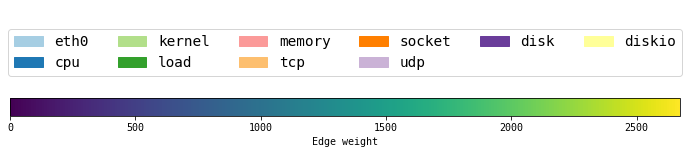

In [27]:
gd.plot_legend_colorbar(
    color_info_by_case['case7'][0], plt.get_cmap("viridis"), 0, 2672,
    # savepath=os.path.join(plot_out_dir, 'graph_legend.png')
)

In [32]:
%matplotlib inline
# for exp_ret in exp_rets:
tic = time.time()
data_idx_to_graph_idx, graph_idx_to_data_idx = gd.construct_d2g_map_dict(
    list(dycause_input.columns), columns_by_case['case7'], print_info=False
)
exp_ret["filtered_dcc"] = gd.filter_dcc(
    exp_ret["dcc"], len(columns_by_case['case7']), graph_idx_to_data_idx
)
exp_ret["filtered_dcc_special"] = gd.filter_dcc(
    exp_ret["dcc_special"], len(columns_by_case['case7']), graph_idx_to_data_idx
)
filtered_df = gd.filter_df(dycause_input, graph_idx_to_data_idx, len(columns_by_case['case7']))
# hints from anomaly dcc
hints = meth_imp.get_dir_hints_from_dcc(exp_ret["filtered_dcc"], len(columns_by_case['case7']), 30)
# merge hints from normal profile
# hints = hints + normal_profile_hints_filtered
# hints = meth_imp.remove_double_direction_hints(hints)

o_s_ids, o_t_ids = get_only_source_target_idx(
    only_source_cols, only_target_cols, list(columns_by_case['case7'])
)
ntop=80
# for ntop in [80]:
mat, candidates = meth_imp.global_thresholding(
    exp_ret["filtered_dcc_special"],
    len(columns_by_case['case7']),
    normal_axis="none",
    ntop=ntop,
    only_source_ids=o_s_ids,
    only_target_ids=o_t_ids,
    hints=hints,
    return_candidates=True
)
exp_ret['time_info']['Graph'] = time.time() - tic
gd.mat_summary(mat)
exp_ret['mat'] = mat
exp_ret['candidates'] = candidates

Num of nonzeros: 80, min=0.0, max=2672.0


In [33]:
# for exp_ret in exp_rets:
tic = time.time()
# corr_res_cond_shuffled, corr_res_cond = calculate_CMIknn_shuffled(mat, filtered_df)
corr_res_cond_shuffled, corr_res_cond = meth_imp.calculate_CMIknn_shuffled_mp(exp_ret['mat'],
                                                                              filtered_df.iloc[-120:, :],
                                                                              max_workers=10, verbose=True)
# corr_res_cond_shuffled = meth_imp.calculate_parcorr(mat, filtered_df)
toc = time.time() - tic
exp_ret['time_info']['Cond'] = toc
exp_ret['corr_res_cond_shuffled'] = corr_res_cond_shuffled

### Edge Correctness Counts

In [1347]:
# r = gd.plot_graph_networkx_igraphlayout(
#     exp_ret['filtered_mat'],
#     color_info_by_case['case7'][1],
#     layout_meth="freingold",
#     savename=os.path.join(plot_out_dir, "igraph-plot", f"best_filtered_mat_freingold.pdf")
# )
correct_edges = {}
for (i, j) in case1to6_correct_edges + case1_correct_edges:
    if i in columns_by_case['case7'] and j in columns_by_case['case7']:
        correct_edges[columns_by_case['case7'].index(i), columns_by_case['case7'].index(j)] = True

wrong_edges = {}
for (i, j) in case1to6_wrong_edges + case1_wrong_edges:
    if i in columns_by_case['case7'] and j in columns_by_case['case7']:
        wrong_edges[columns_by_case['case7'].index(i), columns_by_case['case7'].index(j)] = True

In [1351]:
len(correct_edges), len(wrong_edges)

(12, 16)

In [1392]:
def count_mat(mat):
    N = mat.shape[0]
    counts = {}
    counts['pos_tot'] = len(np.nonzero(mat)[0])
    counts['tp_'] = 0
    for i, j in zip(*np.nonzero(mat)):
        if (i, j) in correct_edges:
            counts['tp_'] += 1
    counts['fp_'] = 0
    for i, j in zip(*np.nonzero(mat)):
        if (i, j) in wrong_edges:
            counts['fp_'] += 1
    counts['pos_unk'] = counts['pos_tot'] - counts['tp_'] - counts['fp_']
    
    counts['neg_tot'] = N * (N-1) - counts['pos_tot']
    counts['tn_'] = 0
    counts['fn_'] = 0
    for i in range(N):
        for j in range(N):
            if mat[i, j] <= 0 and (i, j) in wrong_edges:
                counts['tn_'] += 1
            if mat[i, j] <= 0 and (i, j) in correct_edges:
                counts['fn_'] += 1
    counts['neg_unk'] = counts['neg_tot'] - counts['tn_'] - counts['fn_']
#     print('{} {}({:.2%}) {}({:.2%}) {}({:.2%}) {} {}({:.2%}) {}({:.2%}) {}({:.2%}) '.format(
#         counts['pos_tot'], counts['tp_'], counts['tp_']/counts['pos_tot'], counts['fp_'], counts['fp_']/counts['pos_tot'], counts['pos_unk'], counts['pos_unk']/counts['pos_tot'],
#         counts['neg_tot'], counts['tn_'], counts['tn_']/counts['neg_tot'], counts['fn_'], counts['fn_']/counts['neg_tot'], counts['neg_unk'], counts['neg_unk']/counts['neg_tot'],
#     ), end=' ')
    print('{} {} {} {} {} {} {} {}'.format(
        counts['pos_tot'], counts['tp_'], counts['fp_'], counts['pos_unk'],
        counts['neg_tot'], counts['tn_'], counts['fn_'], counts['neg_unk'],
    ), end=' ')
    print('[{:.2%},{:.2%}] [{:.2%},{:.2%}] [{:.2%},{:.2%}]'.format(
        counts['tp_']/(counts['tp_']+counts['fp_']+counts['pos_unk']), (counts['tp_']+counts['pos_unk'])/(counts['tp_']+counts['fp_']+counts['pos_unk']),
        counts['tp_']/(counts['tp_']+counts['fn_']+counts['neg_unk']), (counts['tp_']+counts['pos_unk'])/(counts['tp_']+counts['pos_unk']+counts['fn_']),
        (counts['tp_']+counts['tn_'])/(counts['pos_tot']+counts['neg_tot']), (counts['tp_']+counts['tn_']+counts['pos_unk']+counts['neg_unk'])/(counts['pos_tot']+counts['neg_tot'])
    ))
    return counts

for mat in [
    exp_ret['filtered_mat'], 
    dycause_all_case_result['case7'][872]['mat'],
    np.array(cr_all_case_result['case7'][80]['others']['access']),
    pcmci_all_case_result['case7'][225]['adj']]:
    
    count_mat(mat)
# count_mat(dycause_all_case_result['case7'][872]['mat'])
# count_mat(np.array(cr_all_case_result['case7'][80]['others']['access']))
# count_mat(pcmci_all_case_result['case7'][225]['adj'])

80 2 0 78 3112 16 10 3086 [2.50%,100.00%] [0.06%,88.89%] [0.56%,99.69%]
169 3 4 162 3023 12 9 3002 [1.78%,97.63%] [0.10%,94.83%] [0.47%,99.59%]
40 2 0 38 3152 16 10 3126 [5.00%,100.00%] [0.06%,80.00%] [0.56%,99.69%]
2192 12 15 2165 1000 1 0 999 [0.55%,99.32%] [1.19%,100.00%] [0.41%,99.53%]


### Case 7 RCA

In [34]:
entry = columns_by_case['case7'].index('load1')
root_causes = [columns_by_case['case7'].index(_) for _ in ["memBuffers", "memCached", "memShmem", "memUsedPercent", "memAvailablePercent"]]
print('entry:', entry, 'root causes:', root_causes)

entry: 13 root causes: [16, 17, 18, 19, 15]


In [36]:
# step=30,lag=7,sign=0.05,p_thr=0.7000000000000001,
params = {
    'mean_method': 'arithmetic',
    'topk_path':400,
    'prob_thres':0.6,
    'num_sel_node':5,
    'out_of_path_nodes': True
}
exp_ret['filtered_mat'] = meth_imp.cond_test_filtering(exp_ret['mat'], exp_ret['candidates'], exp_ret['corr_res_cond_shuffled'], 0.7, lambda x, p: x > p)
tic = time.time()
ranked_nodes, ranked_paths, prks, acc = case_rca_backtrace(
    exp_ret['filtered_mat'], entry, root_causes, filtered_df, **params)
toc = time.time() - tic
exp_ret['time_info']['RCA'] = toc
exp_ana.print_ranked_paths(ranked_paths[:10], columns_by_case['case7'])
exp_ana.print_ranked_nodes(ranked_nodes, columns_by_case['case7'])
print_prk_acc(prks, acc)
print("Total: {:.4f}".format(sum(exp_ret['time_info'].values())), 
          ', '.join([f'{k}: {v:.4f}' for k, v in exp_ret['time_info'].items()]))

0.63: load1,memAvailablePercent,memUsedPercent
0.40: load1,memShmem,retrans,(device=sda)disk.io.util,load5
0.39: load1,memShmem,retrans,(device=sda)disk.io.util,kernelFilesAllocated
0.39: load1,memShmem,(device=sda)disk.io.read,tcpTW,ssClosed,(device=sdb)disk.io.write_bytes_Diff,(device=sda)disk.io.w_wait,user,load5
0.39: load1,memShmem,retrans,(device=sda)disk.io.util,kernelFilesAllocated,(device=sda)disk.io.read,tcpTW,ssClosed,(device=sdb)disk.io.write_bytes_Diff,(device=sda)disk.io.w_wait,user,load5
0.39: load1,memShmem,retrans,(device=sda)disk.io.util,kernelFilesAllocated,(device=sda)disk.io.read,ssClosed,(device=sdb)disk.io.write_bytes_Diff,(device=sda)disk.io.w_wait,user,load5
0.39: load1,memShmem,(device=sda)disk.io.read,ssClosed,(device=sdb)disk.io.write_bytes_Diff,(device=sda)disk.io.w_wait,user,load5
0.39: load1,memShmem,retrans,(device=sda)disk.io.util,kernelFilesAllocated,tcpPkgInsegs
0.38: load1,memShmem,retrans,(device=sda)disk.io.util,kernelFilesAllocated,(device=sda)dis

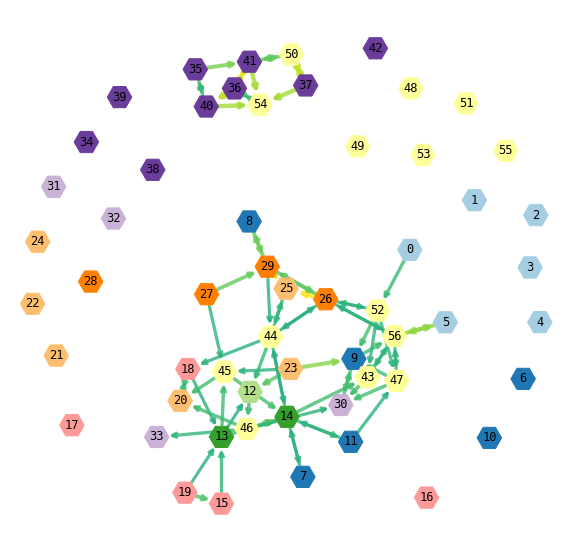

In [38]:
r = gd.plot_graph_networkx_igraphlayout(
    exp_ret['filtered_mat'],
    color_info_by_case['case7'][1],
    layout_meth="freingold",
    # savename=os.path.join(plot_out_dir, f"best_mat_freingold.svg")
)